# **📦 Imports**
We start by importing all the essential Python libraries for our workflow — from **PyTorch** for deep learning to **Matplotlib & Seaborn** for visualizations, and **PIL** for image handling.


In [ ]:
# ==========================================
# 📦 Imports
# ==========================================
import os, time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **🔁 Reproducibility & Device Setup**
To ensure consistent results every time we run the code, we set a random seed for **Python, NumPy, and PyTorch**.  
We also detect if a GPU is available for faster training — otherwise, fallback to CPU.


In [ ]:
# ==========================================
# 🔁 Reproducibility & Device
# ==========================================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# **⚙️ Configuration**
Here we define important configuration parameters such as:
- **Dataset location**  
- **Image size** (for resizing)  
- **Batch size** & **Number of workers**  
- **Learning rate** and **Epochs**  
- **Train/Validation/Test split ratios**  


In [ ]:
# ==========================================
# ⚙️ Config
# ==========================================
DATASET_DIR = "/content/drive/MyDrive/CNN Chest Xray"
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 10
LR = 1e-3

# split ratios
TRAIN_R, VAL_R, TEST_R = 0.70, 0.15, 0.15
assert abs((TRAIN_R + VAL_R + TEST_R) - 1.0) < 1e-6


# **🧼 Data Transformations**
We apply transformations to prepare the dataset for training:
- Resize images to a fixed resolution
- Convert to tensors
- Normalize using ImageNet mean & standard deviation  

We also define an *unnormalize* function to convert normalized images back to a human-viewable format.


In [ ]:
# ==========================================
# 🧼 Transforms
# ==========================================
base_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# For visualizing images we need an "unnormalize"
inv_mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
inv_std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)

def unnormalize(t):
    return torch.clamp(t * inv_std + inv_mean, 0, 1)


# **📂 Load Full Dataset**
We load the dataset from the given directory using **`torchvision.datasets.ImageFolder`**, which automatically detects class subfolders and labels them.  
We then display:
- Class names
- Total image count
- Per-class image counts


In [ ]:
# ==========================================
# 📂 Load full dataset (single folder with class subfolders)
# ==========================================
full_ds = datasets.ImageFolder(DATASET_DIR, transform=base_transform)
class_names = full_ds.classes
num_classes = len(class_names)
targets = np.array([y for _, y in full_ds.samples])  # labels from ImageFolder
print("Classes:", class_names)
print("Total images:", len(full_ds))


Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Total images: 4035


In [ ]:
# ==========================================
# 🔢 Overall per-class counts
# ==========================================
from collections import Counter
overall_counts = Counter(targets.tolist())
for idx, name in enumerate(class_names):
    print(f"{name:>12}: {overall_counts.get(idx,0)}")


       Covid: 1345
      Normal: 1345
Viral Pneumonia: 1345


# **✂️ Stratified Train/Val/Test Split**
To avoid class imbalance issues, we split the dataset **stratified by class labels** into:
- 70% Training
- 15% Validation
- 15% Testing  

We then create `Subset` objects for each split.


In [ ]:
# ==========================================
# ✂️ Stratified split indices (70/15/15)
# ==========================================
def stratified_split_indices(labels, train_r, val_r, test_r, seed=SEED):
    rng = np.random.default_rng(seed)
    labels = np.array(labels)
    cls_indices = {c: np.where(labels==c)[0].tolist() for c in np.unique(labels)}
    train_idx, val_idx, test_idx = [], [], []
    for c, idxs in cls_indices.items():
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(round(train_r * n))
        n_val   = int(round(val_r * n))
        n_test  = n - n_train - n_val
        train_idx += idxs[:n_train]
        val_idx   += idxs[n_train:n_train+n_val]
        test_idx  += idxs[n_train+n_val:]
    # shuffle each split for good measure
    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_split_indices(targets, TRAIN_R, VAL_R, TEST_R)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Train/Val/Test sizes: 2823/606/606


# **📊 Per-Class Counts per Split**
We verify that our splits preserve the **class balance** by counting the number of images for each class in each split.


In [ ]:
# ==========================================
# 📊 Per-class counts per split
# ==========================================
def split_counts(indices, labels, class_names):
    c = Counter(labels[indices])
    return {class_names[k]: c.get(k,0) for k in range(len(class_names))}

train_counts = split_counts(train_idx, targets, class_names)
val_counts   = split_counts(val_idx, targets, class_names)
test_counts  = split_counts(test_idx, targets, class_names)

print("Train per-class:", train_counts)
print("Val per-class  :", val_counts)
print("Test per-class :", test_counts)


Train per-class: {'Covid': 941, 'Normal': 941, 'Viral Pneumonia': 941}
Val per-class  : {'Covid': 202, 'Normal': 202, 'Viral Pneumonia': 202}
Test per-class : {'Covid': 202, 'Normal': 202, 'Viral Pneumonia': 202}


# **🚚 Data Loaders**
We create **PyTorch DataLoaders** for each split to efficiently:
- Batch the data
- Shuffle training samples
- Preload data using multiple workers


In [ ]:
# ==========================================
# 🚚 DataLoaders
# ==========================================
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


# **👀 Visualize One Image per Class**
Before training, we visualize one example from each class **after preprocessing** (resize & normalization) to confirm that the transformations are applied correctly.


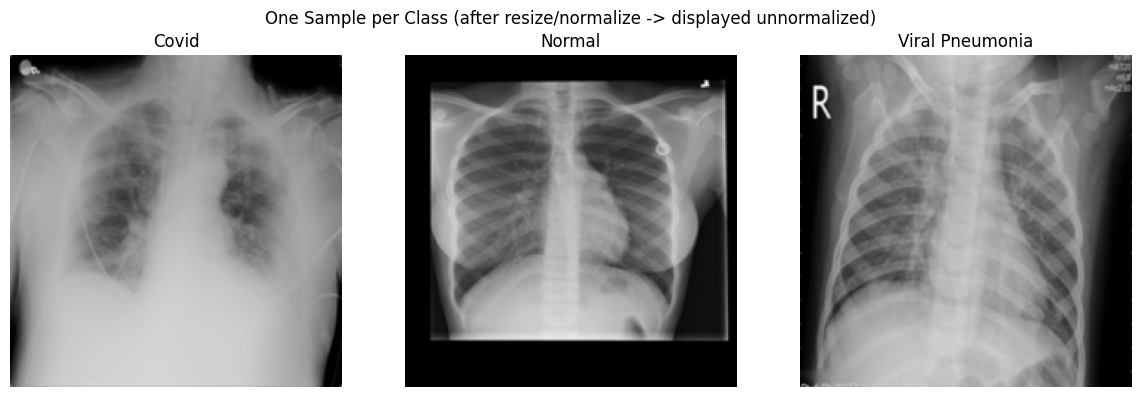

In [ ]:
# ==========================================
# 👀 Visualize one image per class (from full dataset)
# ==========================================
fig, axs = plt.subplots(1, num_classes, figsize=(4*num_classes, 4))
shown = set()
i = 0
for idx in range(len(full_ds)):
    _, label = full_ds.samples[idx]
    if label not in shown:
        img, _ = full_ds[idx]  # transformed (normalized)
        axs[i].imshow(unnormalize(img).permute(1,2,0))
        axs[i].set_title(class_names[label])
        axs[i].axis('off')
        shown.add(label)
        i += 1
        if i == num_classes:
            break
plt.suptitle("One Sample per Class (after resize/normalize -> displayed unnormalized)")
plt.tight_layout()
plt.show()


# **🧠 Setting Up VGG-16 with Pretrained Weights for COVID-19 Classification**

In this step, we load the **VGG-16** architecture from `torchvision.models` with **ImageNet pretrained weights**.  
This gives us a strong starting point since VGG-16 has already learned to extract useful image features.

- **Freezing convolutional layers**:  
  We lock the weights of the feature extractor so training focuses only on the classifier, saving time and reducing overfitting.
  
- **Customizing the classifier**:  
  The original VGG-16 classifier is replaced with a custom version tailored for **3 output classes**:
  1. COVID-19  
  2. Normal  
  3. Viral Pneumonia  

- **Dropout layers** are added between fully connected layers to improve generalization and reduce overfitting.

Finally, if `torchsummary` is available, we print the model summary to inspect the architecture and parameter counts.


In [ ]:
# ==========================================
# 🧠 VGG-16 (Pre-trained Weights)
#
# ==========================================

import torch
import torch.nn as nn
from torchvision import models

# Load pretrained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all convolutional layers (feature extractor)
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier for 3 classes
vgg16.classifier[6] = nn.Linear(
    in_features=vgg16.classifier[6].in_features,
    out_features=3  # Covid, Normal, Viral Pneumonia
)

# Optional: Add dropout for better generalization
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 3)  # final output layer
)

# Check model summary (if torchsummary is installed)
try:
    from torchsummary import summary
    summary(vgg16, (3, 224, 224))
except:
    pass


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 177MB/s]


# **⚡ Loss Function & Optimizer**

With our VGG-16 model ready, the next step is to configure how it will **learn** during training.

- **Freezing layers again (just in case)**:  
  We ensure that only the **classifier layers** are trainable, keeping the feature extractor frozen.

- **Optimizer — AdamW**:  
  We use the **AdamW** optimizer, which combines Adam’s adaptive learning rates with weight decay for better generalization.  
  - **Separate learning rates** are assigned:
    - Feature extractor: `1e-5` (very small, minimal fine-tuning)
    - Classifier: `1e-4` (larger, since it’s being trained from scratch)
  - **Weight decay** (`1e-4`) adds L2 regularization to help prevent overfitting.



In [ ]:
# ==========================================
# ⚡ Loss, Optimizer, Helpers
# ==========================================

import torch.optim as optim

# Unfreeze only classifier layers
for param in vgg16.features.parameters():
    param.requires_grad = False
for param in vgg16.classifier.parameters():
    param.requires_grad = True

# Define optimizer with separate parameter groups
optimizer = optim.AdamW(
    [
        {"params": [p for p in vgg16.features.parameters() if p.requires_grad], "lr": 1e-5},
        {"params": [p for p in vgg16.classifier.parameters() if p.requires_grad], "lr": 1e-4}
    ],
    weight_decay=1e-4  # L2 regularization
)


In [ ]:
# -----------------------------
# 🔧 Device configuration
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()

# **🏋️ Training & Validation Loop**
This function trains the VGG-16 model for multiple epochs, tracking:

- **Training & Validation** loss/accuracy each epoch  
- **Best model saving** when validation accuracy improves  
- **Total time** and **peak GPU memory** usage (if on CUDA)  

It returns the training history, total time taken, and memory usage for later analysis.


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# -----------------------------
# 📦 Training function (with GPU usage & timing)
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS):
    best_val_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Reset GPU peak memory stats if on CUDA
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats()

    # Start timing
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\n📅 Epoch {epoch+1}/{num_epochs}")

        # --- Training Phase ---
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = (running_corrects / total) * 100

        # --- Validation Phase ---
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                preds = torch.argmax(outputs, dim=1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels).item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = (val_corrects / val_total) * 100

        # Store metrics
        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        print(f"🔹 Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
        print(f"🔹 Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.2f}%")

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), "best_vgg16.pth")
            print("💾 Saved new best model!")

    # Total training time
    total_time = time.time() - start_time

    # Peak GPU memory usage (in MB)
    peak_mem_mb = 0.0
    if device.type == "cuda":
        peak_mem_mb = torch.cuda.max_memory_allocated(device) / (1024**2)

    print(f"\n⏳ Training Time: {total_time:.2f} sec")
    print(f"💾 Peak GPU Memory: {peak_mem_mb:.2f} MB")

    return history, total_time, peak_mem_mb


# **🚀 Model Training**
We now train the customized VGG-16 using our training and validation data, recording accuracy, loss, time taken, and peak GPU memory usage..


In [ ]:
# ==========================================
# 🚀 Train
# ==========================================
history, train_time_s, train_peak_mb = train_model(
    model=vgg16,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS
)



📅 Epoch 1/10


🔹 Train Loss: 0.2310 | Train Acc: 92.17%
🔹 Val Loss:   0.1077 | Val Acc:   96.37%
💾 Saved new best model!

📅 Epoch 2/10


🔹 Train Loss: 0.0963 | Train Acc: 97.10%
🔹 Val Loss:   0.0924 | Val Acc:   97.69%
💾 Saved new best model!

📅 Epoch 3/10


🔹 Train Loss: 0.0477 | Train Acc: 98.48%
🔹 Val Loss:   0.1705 | Val Acc:   96.70%

📅 Epoch 4/10


🔹 Train Loss: 0.0331 | Train Acc: 98.90%
🔹 Val Loss:   0.1741 | Val Acc:   97.03%

📅 Epoch 5/10


🔹 Train Loss: 0.0253 | Train Acc: 99.33%
🔹 Val Loss:   0.1590 | Val Acc:   96.70%

📅 Epoch 6/10


🔹 Train Loss: 0.0190 | Train Acc: 99.33%
🔹 Val Loss:   0.1680 | Val Acc:   96.86%

📅 Epoch 7/10


🔹 Train Loss: 0.0116 | Train Acc: 99.54%
🔹 Val Loss:   0.1358 | Val Acc:   97.03%

📅 Epoch 8/10


🔹 Train Loss: 0.0220 | Train Acc: 99.15%
🔹 Val Loss:   0.1442 | Val Acc:   96.20%

📅 Epoch 9/10


🔹 Train Loss: 0.0111 | Train Acc: 99.72%
🔹 Val Loss:   0.2545 | Val Acc:   96.70%

📅 Epoch 10/10


🔹 Train Loss: 0.0281 | Train Acc: 99.08%
🔹 Val Loss:   0.2698 | Val Acc:   96.37%

⏳ Training Time: 767.30 sec
💾 Peak GPU Memory: 4272.32 MB


# **🧪 Testing & Performance Evaluation**
We load the best saved VGG-16 weights and evaluate on the test set, measuring:

- **Loss & Accuracy** on unseen data  
- **Testing time** for performance benchmarking  
- **Peak GPU memory usage** during inference



In [ ]:
# ==========================================
# 🧪 Test metrics (timing + GPU memory)
# ==========================================
vgg16.load_state_dict(torch.load("best_vgg16.pth"))  # Load best model
vgg16.eval()

if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats()

t0 = time.time()

test_loss, test_corrects, test_total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, dim=1)
        test_loss += loss.item() * images.size(0)
        test_corrects += torch.sum(preds == labels).item()
        test_total += labels.size(0)

# Metrics
test_loss /= test_total
test_acc = (test_corrects / test_total) * 100
test_time_s = time.time() - t0

# GPU memory
test_peak_mb = 0.0
if device.type == "cuda":
    test_peak_mb = torch.cuda.max_memory_allocated(device) / (1024**2)

# Results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.2f}%")
print(f"⏳ Test Time: {test_time_s:.2f} sec")
print(f"💾 Peak GPU Memory (Test): {test_peak_mb:.2f} MB")


Test Loss: 0.0712
Test Acc : 97.03%
⏳ Test Time: 102.36 sec
💾 Peak GPU Memory (Test): 4272.32 MB


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# ==========================================
# 🧪 Test evaluation (metrics + report + confusion matrix)
# ==========================================
# Load best saved model
vgg16.load_state_dict(torch.load("best_vgg16.pth"))
vgg16.eval()

# Reset GPU peak memory stats if CUDA
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats()

# Start timer
t0 = time.time()

# Metrics tracking
test_loss, test_corrects, test_total = 0.0, 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, dim=1)

        # Loss & accuracy
        test_loss += loss.item() * images.size(0)
        test_corrects += torch.sum(preds == labels).item()
        test_total += labels.size(0)

        # Store predictions for report
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

# Final metrics
test_loss /= test_total
test_acc = (test_corrects / test_total) * 100
test_time_s = time.time() - t0

# Peak GPU memory usage
test_peak_mb = 0.0
if device.type == "cuda":
    test_peak_mb = torch.cuda.max_memory_allocated(device) / (1024**2)

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.2f}%")
print(f"⏳ Test Time: {test_time_s:.2f} sec")
print(f"💾 Peak GPU Memory (Test): {test_peak_mb:.2f} MB")



Test Loss: 0.0712
Test Acc : 97.03%
⏳ Test Time: 4.32 sec
💾 Peak GPU Memory (Test): 4272.32 MB


# **📑 Classification Report**
Generates precision, recall, and F1-score for each class to assess the model’s detailed performance.


In [ ]:
# ==========================================
# 📑 Classification report
# ==========================================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))




Classification Report:
                 precision    recall  f1-score   support

          Covid     0.9852    0.9901    0.9877       202
         Normal     0.9793    0.9356    0.9570       202
Viral Pneumonia     0.9476    0.9851    0.9660       202

       accuracy                         0.9703       606
      macro avg     0.9707    0.9703    0.9702       606
   weighted avg     0.9707    0.9703    0.9702       606



# **🔍 Confusion Matrix**

Visualizes how well the model distinguishes between classes by showing correct and incorrect predictions.


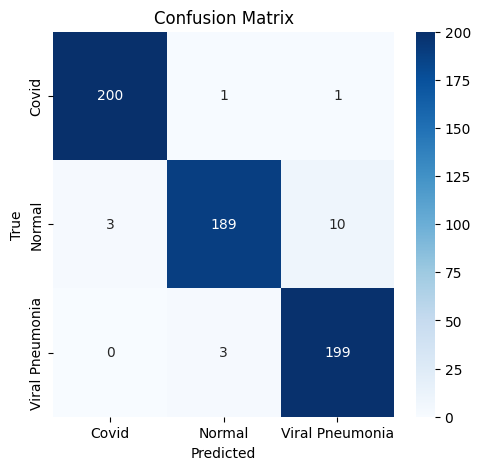

In [ ]:
# ==========================================
# 🔍 Confusion matrix
# ==========================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# **📊 Overall Model Performance**
We display a bar chart showing:
- Accuracy
- Precision
- Recall
- F1-score  
All values are in percentage format for easy interpretation.


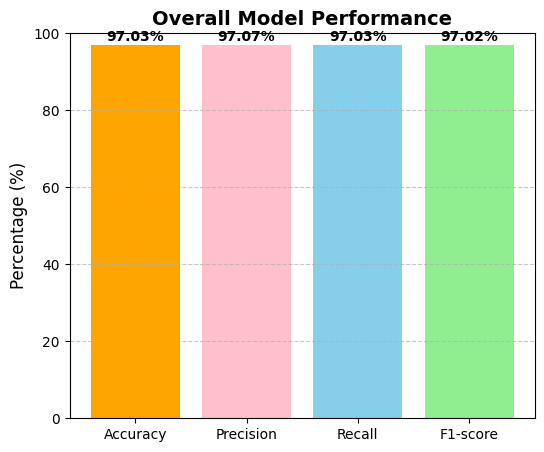

In [ ]:
import matplotlib.pyplot as plt

# Overall metrics from your results
metrics = {
    "Accuracy": 97.03,
    "Precision": 97.07,
    "Recall": 97.03,
    "F1-score": 97.02
}

# Create bar plot
plt.figure(figsize=(6, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=['orange', 'pink', 'skyblue', 'lightgreen'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.2f}%",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
plt.ylim(0, 100)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("Overall Model Performance", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# **🖼️ Test Predictions — Truth vs Predicted**
We randomly display several test images along with:
- True label (T)
- Predicted label (P)  
If the prediction is correct, the title is green; if wrong, it's red.


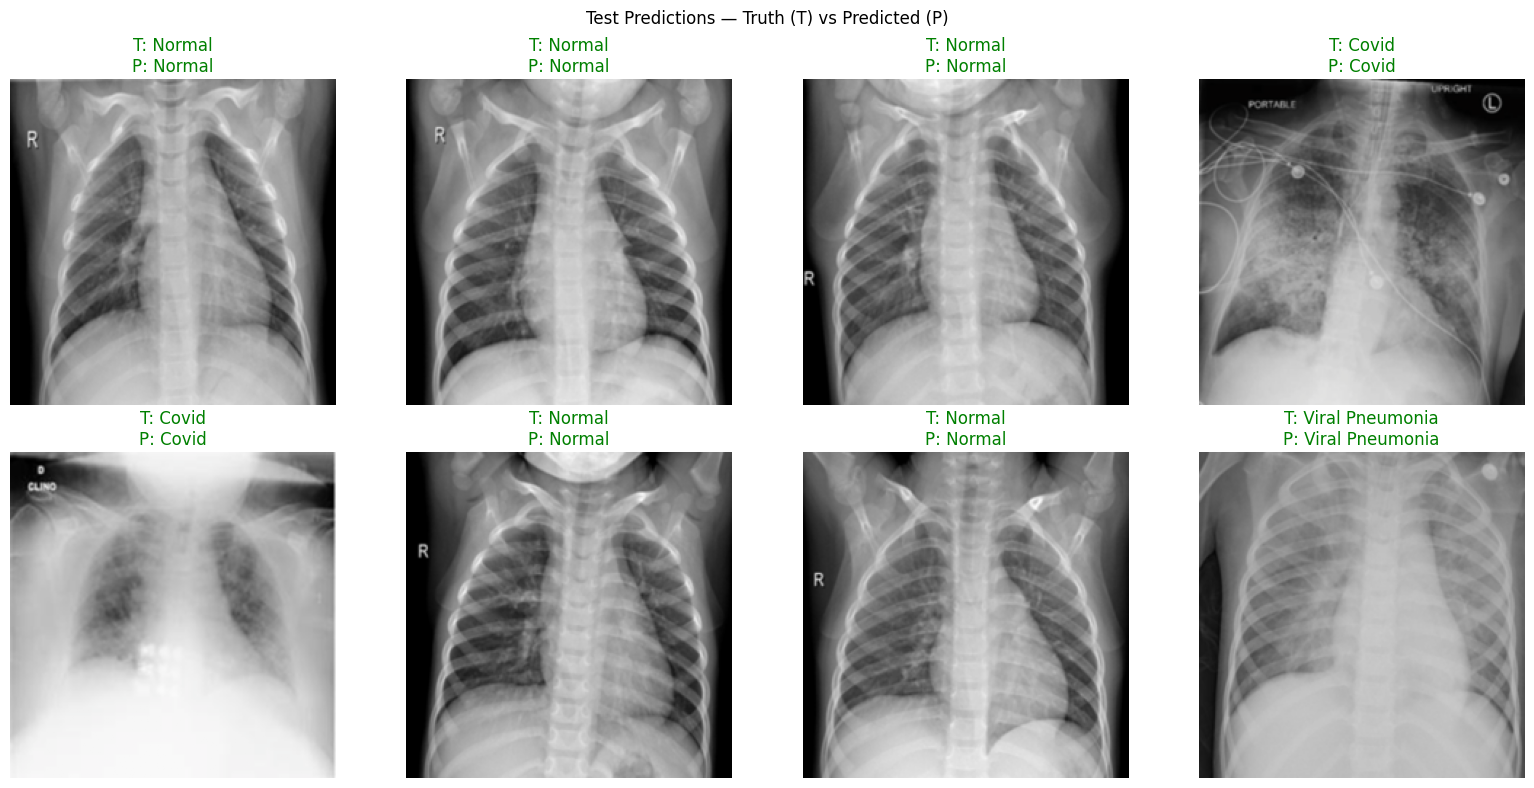

In [ ]:
import math

# ==========================================
# 🖼️ Visual predictions on test images (truth vs predicted)
# ==========================================
vgg16.eval()
images_shown = 8  # number of test images to show

# Helper: unnormalize image (if normalization was applied in transforms)
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])  # ImageNet means
    std  = torch.tensor([0.229, 0.224, 0.225])  # ImageNet stds
    return img * std[:, None, None] + mean[:, None, None]

imgs_list, labels_list, preds_list = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = vgg16(imgs)
        preds = torch.argmax(logits, dim=1)

        imgs_list.append(imgs.cpu())
        labels_list.append(labels.cpu())
        preds_list.append(preds.cpu())

        if sum(batch.size(0) for batch in imgs_list) >= images_shown:
            break

# Combine batches and take only the first N
imgs_cat = torch.cat(imgs_list)[:images_shown]
labels_cat = torch.cat(labels_list)[:images_shown]
preds_cat  = torch.cat(preds_list)[:images_shown]

# Plot grid
cols = 4
rows = math.ceil(images_shown / cols)
plt.figure(figsize=(4*cols, 4*rows))

for i in range(images_shown):
    plt.subplot(rows, cols, i+1)
    plt.imshow(unnormalize(imgs_cat[i]).permute(1, 2, 0).numpy().clip(0, 1))
    t = class_names[labels_cat[i].item()]
    p = class_names[preds_cat[i].item()]
    color = "green" if t == p else "red"
    plt.title(f"T: {t}\nP: {p}", color=color)
    plt.axis('off')

plt.suptitle("Test Predictions — Truth (T) vs Predicted (P)")
plt.tight_layout()
plt.show()


# **📈 Confidence Distribution**
We visualize the model's **confidence scores** for:
- Correct predictions
- Incorrect predictions  
This helps understand whether the model is overconfident in wrong predictions.


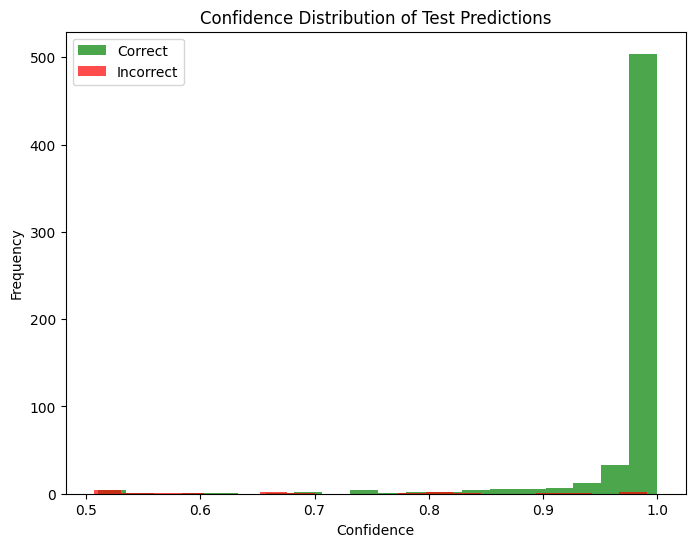

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ==========================================
# 📊 Confidence distribution (reuse test predictions)
# ==========================================
vgg16.eval()

all_probs, all_labels = [], []

# Use the already collected y_true and y_pred from testing
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = vgg16(imgs)
        probs = F.softmax(logits, dim=1)

        # Max probability = confidence
        all_probs.extend(probs.max(1).values.cpu().numpy())
        # Correct predictions = True/False
        all_labels.extend((probs.argmax(1).cpu().numpy() == labels.numpy()))

# Separate confidences for correct vs incorrect predictions
correct_conf = [p for p, c in zip(all_probs, all_labels) if c]
incorrect_conf = [p for p, c in zip(all_probs, all_labels) if not c]

# Plot histogram
plt.figure(figsize=(8,6))
plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect', color='red')
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Confidence Distribution of Test Predictions")
plt.legend()
plt.show()


# **🌐 t-SNE Feature Visualization**

Reduces high-dimensional features from the model’s penultimate layer to **2D** using t-SNE, allowing us to visually inspect how well the model separates different classes in feature space.


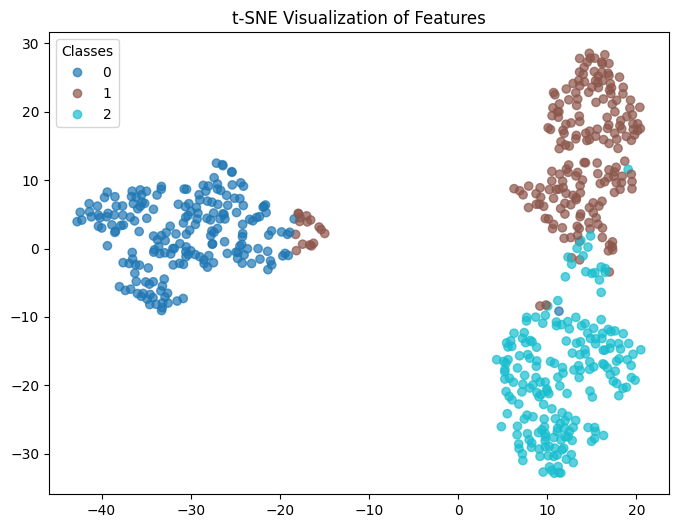

In [ ]:
# ==========================================
# 📌 t-SNE Visualization of Features
# ==========================================
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vgg16.eval()
features, labels_list = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Using penultimate layer features for VGG16
        feats = vgg16.classifier[:-1](vgg16.features(images).view(images.size(0), -1))

        features.append(feats.cpu())
        labels_list.append(labels.cpu())

# Stack all features and labels
features = torch.cat(features)
labels_list = torch.cat(labels_list)

# Optional: sample subset if dataset is large (e.g., 500 samples)
# idx = torch.randperm(features.size(0))[:500]
# features = features[idx]
# labels_list = labels_list[idx]

# Reduce features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_list, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of Features")
plt.show()


# **🚫 Misclassified Samples**
We display a grid of images that the model misclassified, with:
- True label
- Predicted label (in red)  
This helps identify common failure patterns in the model.


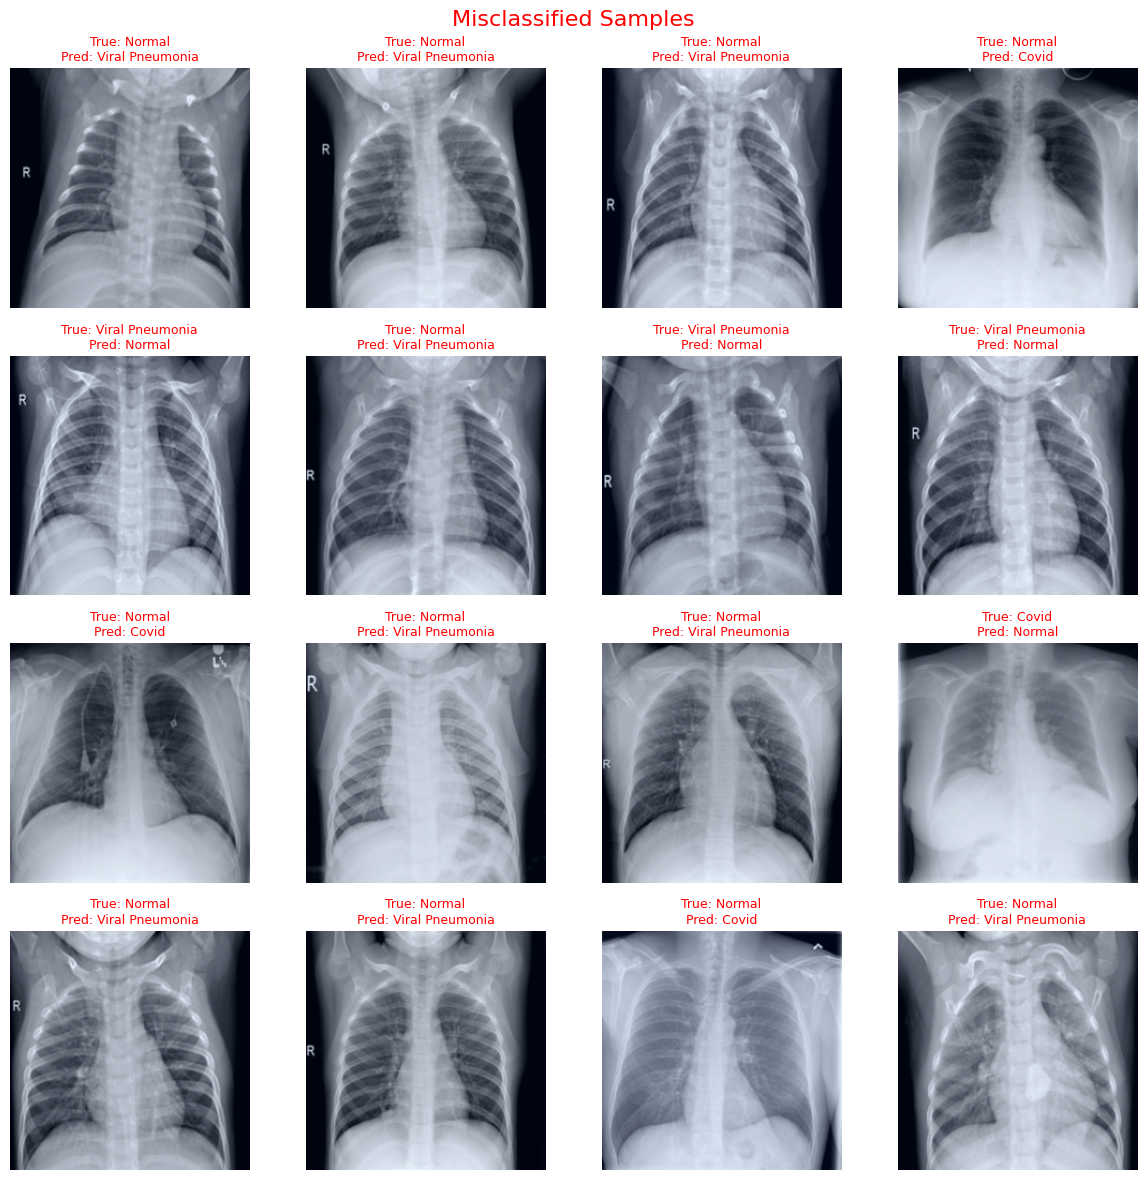

In [ ]:
# ==========================================
# ❌ Visualize Misclassified Test Samples
# ==========================================
vgg16.eval()
misclassified_images = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect misclassified images
        for i in range(len(preds)):
            if preds[i] != targets[i]:
                misclassified_images.append(inputs[i].cpu())
                true_labels.append(targets[i].item())
                pred_labels.append(preds[i].item())

# Display first 16 misclassified samples
plt.figure(figsize=(12, 12))
for idx in range(min(16, len(misclassified_images))):
    img = misclassified_images[idx].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display

    plt.subplot(4, 4, idx+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}",
              fontsize=9, color='red')
    plt.axis('off')

plt.suptitle("Misclassified Samples", fontsize=16, color='red')
plt.tight_layout()
plt.show()
